<h1 style="text-align: center; color: #8D7334; font-weight: bold; font-style: italic; text-decoration: underline; "> Histopathologic Cancer Detection using Covolutional Neural Networks (CNNs)</h1>

<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  University of Colorado Boulder </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  Master of Data Science </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  DTSA 5511 Introduction to Deep Learning -- Week 3 -- Final Project -- </h2>
<br>
<br>
<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Introduction and Key Objectives:</h3>
Cancer detection has been a priority for the medical community for decades. Early detection and treatment may be the difference between life and otherwise. Digital technologies have helped the medical community in this effort. This project's main objective is to identify images with cancer based on an algorithm trained on thousands of images known to contain (and not contain) cancer cells. At a more technical level, the objective translates into training a model with thousands of labelled images, and label new unseen images. In this particular case, the new unseen images used in the validation and testing sets have labels as well, and that allows us to measure the performance of the model in terms of its accuracy in predicting the correct label for each image.


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Data Source:</h3>
The original data source is PatchCamelyon (PCam), a new and challenging image classification dataset. It consists of 327,680 color 96 x 96 pixels images extracted from histopathologic scans of lymph node sections, with each image labelled 0 or 1 with 1 indicating the presence of metastatic tissue--.
The data is stored in gzipped HDF5 files and can be downloaded from Kaggle https://www.kaggle.com/c/histopathologic-cancer-detection using the link under 'benchmark dataset', or directly from this github page:

https://github.com/basveeling/pcam

The initial data download of the .gz files is manual. 

xTrainh5 = "camelyonpatch_level_2_split_train_x.h5.gz" 
yTrainh5 = "camelyonpatch_level_2_split_train_y.h5.gz"

xTesth5 = "camelyonpatch_level_2_split_test_x.h5.gz"
yTesth5 = "camelyonpatch_level_2_split_test_y.h5.gz"

xValidh5 = "camelyonpatch_level_2_split_valid_x.h5.gz"
yValidh5 = "camelyonpatch_level_2_split_valid_y.h5.gz"

Thereafter, the decompression into .h5, flatenning to .tiff, and final creation of .csv run automatically through the code. The images are stored in 3 folders: trainSet, testSet, validSet, which need to be created prior to runnning the code as subdirectories of the directory in which the code runs. 


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Import Libraries and Basic File Adjustments:</h3>


In [1]:
import os
import gzip
import shutil
import h5py
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import pickle
import random
# Image Processing Packages
from PIL import Image
import hashlib

# Metrics
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

#========================================================
# Set seed for reproducible results.
SEED = 2025
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
#==========================================================

# These gz files are downloaded first from the https://github.com/basveeling/pcam repository.
# These are the original files used in the Kaggle competition.

# Training Set:
xTrainh5 = "camelyonpatch_level_2_split_train_x.h5.gz" 
yTrainh5 = "camelyonpatch_level_2_split_train_y.h5.gz"
# Testing Set:
xTesth5 = "camelyonpatch_level_2_split_test_x.h5.gz"
yTesth5 = "camelyonpatch_level_2_split_test_y.h5.gz"
#Validation Set
xValidh5 = "camelyonpatch_level_2_split_valid_x.h5.gz"
yValidh5 = "camelyonpatch_level_2_split_valid_y.h5.gz"

filesList = [xTesth5, yTesth5, xTrainh5, yTrainh5, xValidh5, yValidh5]

# gz file to h5: 
def print_all(name):
    print("\nLine 34 name:", name)

def convertgzh5( inputFile):
    outputFile = inputFile[:len(inputFile)-3]
    with gzip.open(inputFile, 'rb') as fin:
            with open(outputFile, 'wb') as fout:
                    shutil.copyfileobj(fin, fout)
#convertgzh5(yTrainh5)

def makeTiff(x, y, dirBase):
    # Operate over x first:
    hexNames = []
    outputDir = dirBase
    fileName = x[:len(x)-3]
    
    # Open the .h5 file
    with h5py.File(fileName, 'r') as f: # first level keys.
            keys = list(f.keys())
            print("\n Line 56 Keys in file:", keys)
            for key in f.keys(): # first level keys.
                    print("\nLine 58: ", key, f[key].shape, f[key].dtype)

            keyName = keys[0] #If more than 1 key, this needs to change.
            images = f[keyName][:] #shape: (32768, 96, 96, 3)
            print("\nLine 62 images ids of shape ", images.shape )
                    
            # Make a hexadecimal Name based on image features:
            for i, imgArray in enumerate(images):
                    if( i % 10000 == 0):
                            print("\nLine 67 processing image", i,"of", len(images) )
                    hexName = hashlib.sha1(imgArray.tobytes()).hexdigest()
                    hexNames.append(hexName)
                    img = Image.fromarray(imgArray.astype(np.uint8))
                    img.save(os.path.join(outputDir, f"{hexName}.tiff"))
    
    
    # Now do y:
    yh5FileName = y[:-3]
    print("\nLine 76 processing y file", yh5FileName)
    with h5py.File(yh5FileName, 'r') as f:
            yLabels = f[ "y" ][:].squeeze() #Remove singleton dimensions

    # Save to CSV
    print("\nLine 81 save y file", yh5FileName, "to csv.")
    pd.DataFrame(yLabels, columns=['yLabel']).to_csv( dirBase+".csv", index=False)

    return hexNames, yLabels


# The file decompression and conversion code takes a long to run and it runs only once.
# Once a .csv file is created, this piece of code does not run again.
if os.path.isfile("trainDF.csv"):
    print("\nLine 89: trainDF exists.")
else:
    hexNames, yLabels = makeTiff(xTrainh5, yTrainh5, "trainSet")
    print("\nLine 87 build and save DF", "trainSet")
    trainDF = pd.DataFrame( {"ImageID": hexNames, "yLabel": yLabels } )
    trainDF.to_csv( "trainDF" +".csv", index=False)

if os.path.isfile("validDF.csv"):
    print("\nLine 97: validDF exists.")
else:
    hexNames, yLabels = makeTiff(xValidh5, yValidh5, "validSet")
    print("\nLine 100 build and save DF", "validSet")
    validDF = pd.DataFrame( {"ImageID": hexNames, "yLabel": yLabels })
    validDF.to_csv( "validDF" +".csv", index=False )

if os.path.isfile("testDF.csv"):
    print("\nLine 105: testDF exists.")
else:
    hexNames, yLabels = makeTiff(xTesth5, yTesth5, "testSet")
    print("\nLine 108 build and save DF", "testSet")
    testDF = pd.DataFrame( {"ImageID": hexNames, "yLabel": yLabels })
    testDF.to_csv( "testDF" +".csv", index=False )




/home/lrt/.local/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/lrt/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lrt/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-05-30 13:40:44.151941: E external/local_xla/xla/stream_exe


Line 89: trainDF exists.

Line 97: validDF exists.

Line 105: testDF exists.


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Directories, Code high level Structure, and Preprocessing: </h3>
The main download and decompression creates 3 main .csv files to which I refer during the rest of the development of the project. It also stores the training, testing, and validation images in 3 different folders --which need to be created prior to running the code--. The folder names are: trainSet, testSet, validSet.

Some images are duplicated in the initial download. I remove them below as part of the preprocessing step. Other than that, I found the data to be clean and usable right away.

In [2]:
# Get the basic shape of dataframes, and initiate the preprocessing:
dictDF = {}
listDF = [ "trainDF", "validDF", "testDF"]
sizeDF = []
for i in range(len(listDF)):
    # Get shape information of the dataframes:
    tempName = listDF[i]
    tempDF = pd.read_csv( tempName + ".csv")
    dictDF[ tempName] = tempDF
    #print("\nLine 118", tempName,":\n")
    #tempDF.info()
    sizeDF.append(tempDF.shape[0])

    # Check and remove duplicates; keep first occurence:
    uniqueIDs = tempDF.iloc[:,0].unique()
    if( len(uniqueIDs) < tempDF.shape[0]):
            print("\nLine 125: There are duplicates in", tempName, "unique=", len(uniqueIDs), "out of total=", tempDF.shape[0])
            tempDF.drop_duplicates(inplace=True)
            tempDF.to_csv( tempName +".csv", index=False )

    # Output without duplicates:
    print("\nLine 129", tempName,":\n")
    tempDF.info()
    print("\n", tempDF.iloc[0], "\n")

# Total size and test/train, validation/train ratios
print("\nLine 137 Total size=", np.sum(sizeDF))
print("\nLine 138 Train size=", sizeDF[0])
print("\nLine 139 Validation size=", sizeDF[1])
print("\nLine 140 Test size=", sizeDF[2])
print("\nLine 141 Validation/Train % =", round(sizeDF[1]/sizeDF[0]*100,2))
print("\nLine 142 Test/Train % =", round(sizeDF[2]/sizeDF[0]*100,2))


Line 129 trainDF :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ImageID  220025 non-null  object
 1   yLabel   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

 ImageID    179015706f51701c0a67181a59bea1ffe3becbf2
yLabel                                            0
Name: 0, dtype: object 


Line 129 validDF :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28108 entries, 0 to 28107
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  28108 non-null  object
 1   yLabel   28108 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 439.3+ KB

 ImageID    7ed75049c03bc60f3ee3d88f9fb05ed4e038d512
yLabel                                            1
Name: 0, dtype: object 


Line 129 testDF :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 

The output of the this preprocessing cleaning step is 3 clean datasets with unique images (no duplicates) --trainDF (circa 74%), validDF(circa 13%), setDF (circa 13%)-- stored locally in a .csv file. 

Each file contains a hexadecimal imageID, and a label indicating whether the image represents a cancer cell or not. 

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Exploratory Data Analysis (EDA):</h3>
The data consists of images. The first 10 images on the training set look as follows:



Line : Single Image Format
 TIFF (96, 96) RGB


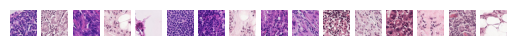

<Figure size 2000x1000 with 0 Axes>

In [3]:
trainDF = pd.read_csv("trainDF.csv")
cwd = os.getcwd()
trainPath = cwd + "/trainSet/"
nDisplay = 16
for i, imgName in enumerate( trainDF["ImageID"].head(nDisplay) ):
    imageFilePathTemp = trainPath+imgName + ".tiff"
    imageTemp = Image.open( imageFilePathTemp )
    if i == 0:
        print("\nLine : Single Image Format\n" ,imageTemp.format, imageTemp.size, imageTemp.mode)
    plt.subplot(1, nDisplay, i+1)
    plt.imshow(imageTemp)
    plt.axis('off')
fig = plt.figure()
fig.set_size_inches(20, 10)  # 10 inches wide, 4 inches tall
plt.tight_layout()
plt.show()


Some of these images are labelled "0" (no cancer present) and otehrs "1" (cancer is present). These images don't say much to the non-expert. A trained expert may be able to get insights from them, but does she have the time to review 300,000 of them?. This is where CNN technologies can help.

I will verify that the images are all of the same size. This piece of code is slow to run as it goes through all images one by one. It runs only once.

In [4]:
def imageSizeCheck( df, filePath ):
    offSize = []
    for i, imgName in enumerate( df["ImageID"] ):
            imageFilePathTemp = filePath+imgName + ".tiff"
            imageTemp = Image.open( imageFilePathTemp )
            imageTempSize= imageTemp.size
            if( imageTempSize != (96,96) ):
                    print("\nLine 173: Flag this image i=", i, "id=", imgName, "has a different size.\n")
                    offSize.append(i) # add the index of the offsize image.
            else:
                    if( i % 10000 == 0 ):
                            print("\nLine 175: i=", i)
    print("\nLine 180: offSize=", offSize)
    return offSize

print("\nLine 182: Check Train set image sizes:\n")
#offsizeTrain = imageSizeCheck(trainDF, trainPath)
print("\nLine 184: The Train set has", sum(trainDF["yLabel"]), "label in 1 indicating the presence of cancer.\n This is about", round(sum(trainDF["yLabel"])/trainDF.shape[0]*100,0) , "percent of the total set.")

testDF = pd.read_csv("testDF.csv")
testPath = cwd + "/testSet/"
print("\nLine 188: Check Test set image sizes:\n")
#offsizeTest = imageSizeCheck(testDF, testPath)
print("\nLine 191: The Test set has", sum(testDF["yLabel"]), "label in 1 indicating the presence of cancer.\n This is about", round(sum(testDF["yLabel"])/testDF.shape[0]*100,0) , "percent of the total set.")

validDF = pd.read_csv("validDF.csv")
validPath = cwd + "/validSet/"
print("\nLine 193: Check Validation set image sizes:\n")
#offsizeValid = imageSizeCheck(validDF, validPath)
print("\nLine 198: The validation set has", sum(validDF["yLabel"]), "label in 1 indicating the presence of cancer.\n This is about", round(sum(validDF["yLabel"])/validDF.shape[0]*100,0) , "percent of the total set.")




Line 182: Check Train set image sizes:


Line 184: The Train set has 89117 label in 1 indicating the presence of cancer.
 This is about 41.0 percent of the total set.

Line 188: Check Test set image sizes:


Line 191: The Test set has 12994 label in 1 indicating the presence of cancer.
 This is about 44.0 percent of the total set.

Line 193: Check Validation set image sizes:


Line 198: The validation set has 11722 label in 1 indicating the presence of cancer.
 This is about 42.0 percent of the total set.


All images are the same size (96x96) and are of the RGB class. About 40% or so of them show a cancer indication (label set to 1). That mix of 40% positive / 60% negative is quite consistent across the three data sets.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Data wrangling to fit Tensorflow:</h3>
The train and validation sets are now adjusted to the format required by Tensorflow. The label should be converted to a string, and the Image ids should include the file .tiff extension.


In [5]:
trainDF["yLabelStr"] = trainDF["yLabel"].copy()
trainDF["yLabelStr"]= trainDF["yLabelStr"].astype("string")
trainDF["fileName"] = trainDF["ImageID"].copy()
for i in range( trainDF.shape[0]):
    #trainDF.loc[i,"yLabelStr"] = str(trainDF.loc[i,"yLabel"]) # make the label a string.
    trainDF.loc[i,"fileName"] = trainDF.loc[i,"ImageID"] + ".tiff" # make the label a string.

validDF["yLabelStr"] = validDF["yLabel"].copy()
validDF["yLabelStr"]= validDF["yLabelStr"].astype("string")
validDF["fileName"] = validDF["ImageID"].copy()
for i in range( len(validDF["yLabelStr"])):
    #validDF.loc[i, "yLabelStr"] = str(validDF.loc[i,"yLabel"]) # make the label a string.
    validDF.loc[i,"fileName"] = validDF.loc[i,"ImageID"] + ".tiff" # make the label a string.


testDF["yLabelStr"] = testDF["yLabel"].copy()
testDF["yLabelStr"]= testDF["yLabelStr"].astype("string")
testDF["fileName"] = testDF["ImageID"].copy()
for i in range( len(testDF["yLabelStr"])):
    #testDF.loc[i, "yLabelStr"] = str(testDF.loc[i,"yLabel"]) # make the label a string.
    testDF.loc[i,"fileName"] = testDF.loc[i,"ImageID"] + ".tiff" # make the label a string.

print(testDF.head())
print(testDF.info())

def plotHistoryF(history):
    historyD = history.history
    historyD.keys()
    trainAcc = historyD['accuracy']
    validAcc = historyD['val_accuracy']
    trainLoss = historyD['loss']
    validLoss = historyD['val_loss']
    
    epochs = range(1, len(trainAcc) + 1)
    fig1, ax1 = plt.subplots(1)
    ax1.plot(epochs, trainLoss, 'rx', label='Training Loss')
    ax1.plot(epochs, validLoss, color='#CFB87C', linestyle=':', label='Validation Loss')
    ax1.set_title('Training and validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    #fig1.savefig("cnnLossPlot.png")
    plt.show()
    
    fig2, ax2 = plt.subplots(1)
    ax2.plot(epochs, trainAcc, 'rx', label='Training Accuracy')
    ax2.plot(epochs, validAcc, color='#CFB87C', linestyle=':', label='Validation Accuracy')
    ax2.set_title('Training and validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper left')
    #fig2.savefig("cnnAccPlot.png")
    plt.show()
    return



                                    ImageID  yLabel yLabelStr  \
0  67acada051970ab2bb750da0d7ea997daed9edf6       0         0   
1  75c03b15de7805115de6e5a4c81225fde8dea523       1         1   
2  6df1bf584ce3cb234f600ad120da339049b9508a       0         0   
3  47345a658666aa524c95e68790a430f0b97b71d5       1         1   
4  dcef0ea7de74d401ae6354b56ed2fb96dfbb7dc7       1         1   

                                        fileName  
0  67acada051970ab2bb750da0d7ea997daed9edf6.tiff  
1  75c03b15de7805115de6e5a4c81225fde8dea523.tiff  
2  6df1bf584ce3cb234f600ad120da339049b9508a.tiff  
3  47345a658666aa524c95e68790a430f0b97b71d5.tiff  
4  dcef0ea7de74d401ae6354b56ed2fb96dfbb7dc7.tiff  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImageID    29383 non-null  object
 1   yLabel     29383 non-null  int64 
 2   yLabelStr  29383 non-null  string


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Modelling and Optimizing:</h3>
Prior to selecting the final architecture and structure for the project, I reviewed close to a dozen models available in Github to get a feel what has worked (and not worked), and to start with one that is more or less off to a good start (see list in the references section). 
I settled with a model with 3 cnn layers and soon realized that the training time is in hours (parameterGrid1).

buildCNNModel is the main core function, along with cnnParameterGridSearch which helps fine tune the hyperparameters based on a parameter grid strategy.

A grid search to optimize 9 hyperparameters with just 2 options for each delivers 2^9= 512 models. Depending on the input parameters each one of the 512 options can take between 5 hours and 9 hours to train on the complete dataset in my system, about 3+ months in total.

While the grid search is still running in the background, I selected a small fraction of 100 images of the training and validation sets (parameterGrid2), and made sure that the overall code could flows from the beginning of training and validation until the end testing, with a low number of epoch iterations. 

For the final run, I selected one value for each hyperparameter and applied it to the entire training and validation sets parameterGrid3. The training takes about 9 hours with 15 epochs, and achieved 85% accuracy on the validation set.

I run this report with a more practical set of parameters in parameterGrid4 which is able to achieve close to 80% with a 20-minute run.



In [6]:
inputShape = (96,96,3)

parameterGrid1={"batchSize": [32,64],"nStrides": [2,3], "nEpoch": [5, 10 ], "eta": [0.0005, 0.0001, 0.00001], "nFilters1": [32,64], "nFilters2": [32,64], "kernelSize": [ (3,3), (5,5) ], "nTrain": [160000, trainDF.shape[0]], "nValid": [10000, validDF.shape[0]]}
parameterGrid2={"batchSize":[64],"nStrides":[2],"nEpoch":[5],"eta":[0.0001],"nFilters1":[64],"nFilters2":[32], "kernelSize": [(3,3)],"nTrain":[1000],"nValid": [1000]}
parameterGrid3={"batchSize":[64],"nStrides":[2],"nEpoch":[15],"eta":[0.0001],"nFilters1":[64],"nFilters2":[32], "kernelSize": [(3,3)],"nTrain":[trainDF.shape[0]],"nValid": [validDF.shape[0]]}
parameterGrid4={"batchSize":[64],"nStrides":[2],"nEpoch":[20],"eta":[0.0001],"nFilters1":[64],"nFilters2":[32], "kernelSize": [(3,3)],"nTrain":[2000],"nValid": [2000]}
parameterGrid5={"batchSize":[64],"nStrides":[2],"nEpoch":[1],"eta":[0.0001],"nFilters1":[64],"nFilters2":[32], "kernelSize": [(3,3)],"nTrain":[220000],"nValid": [20000]}

dataGen = ImageDataGenerator(rescale=1/255) # rescale the data.

def buildCNNModel( nFilter1=64, nFilter2=32, kSize=(3,3), keta=0.0001, nTrain=trainDF.shape[0], nValid=validDF.shape[0], nStrides=2):
    batchSize = 100
    #dataGen = ImageDataGenerator(rescale=1/255) # rescale the data.
    training = dataGen.flow_from_dataframe(
            dataframe = trainDF.iloc[:nTrain, ],
            directory = trainPath,
            x_col = "fileName",
            y_col = "yLabelStr",
            batch_size = batchSize,
            shuffle = False,
            class_mode = 'binary', #binary labels need to be strings
            target_size = (96,96),
            seed = 2025,
            validate_filenames = True
            )
    
    validation = dataGen.flow_from_dataframe(
            dataframe = validDF.iloc[:nValid, ],
            directory = validPath,
            x_col = "fileName",
            y_col = "yLabelStr",
            batch_size = batchSize,
            shuffle = False,
            class_mode = 'binary', #binary labels need to be strings
            target_size = (96,96),
            seed = 2025,
            validate_filenames = True
            )
    
    cnnModel = tf.keras.Sequential([
    layers.Conv2D(nFilter1, kernel_size=kSize, padding='same', activation='relu', input_shape=inputShape),
    layers.MaxPooling2D(pool_size=kSize, strides=nStrides, padding='same'),
    layers.Conv2D(nFilter2, kernel_size=kSize, padding='same', activation='relu', input_shape=inputShape),
    layers.MaxPooling2D(pool_size=kSize, strides=nStrides, padding='same'),
    layers.Conv2D(16, kernel_size=kSize, padding='same', activation='relu', input_shape=inputShape),
    layers.MaxPooling2D(pool_size=kSize, strides=nStrides, padding='same'),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])
    cnnModel.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=keta))
    cnnModel.summary()
    return cnnModel, training, validation


The best model, parameters, and results are saved to disk for future upload without having to go through the costly training process.

In [7]:
# Grid search
def cnnParamsGridSearch(parameterGrid):
    best_val_acc = 0
    resultsL = []
    bestResultD =None
    bestHistory = None
    bestModel = None
    for eta in parameterGrid["eta"]:
            for bs in parameterGrid['batchSize']:
                    for nf1 in parameterGrid["nFilters1"]:
                            for nf2 in parameterGrid["nFilters2"]:
                                    for ks in parameterGrid["kernelSize"]:
                                            for nT in parameterGrid["nTrain"]:
                                                    for nV in parameterGrid["nValid"]:
                                                            for nS in parameterGrid["nStrides"]:
                                                                    for nEp in parameterGrid["nEpoch"]:
                                                                            print("\nLine 312: Training with eta=", eta, "batchSize=",bs, "nFilters1=",nf1, "nFilters2=",nf2, "Epoch=", nEp)
                                                                            print("\n=======================================================================================================")
                                                                            cnnModel, training, validation = buildCNNModel(nf1, nf2, ks, eta, nT, nV, nS )
                                                                            history = cnnModel.fit(x=training, validation_data=validation, epochs=nEp, batch_size=bs) # verbose=0
                                                                            val_acc = max(history.history['val_accuracy'])
                                                                            tempResultD = {'params': {"batchSize": bs,"nStrides": nS,"nEpoch": nEp,"eta":eta,"nFilters1":nf1,"nFilters2":nf2, "kernelSize": ks,"nTrain":nT,"nValid": nV}, 'validAccuracy': val_acc}
                                                                            resultsL.append( tempResultD )
                                                                            print("\nLine 321: Results:\n", resultsL)
                                                                            if val_acc > best_val_acc:
                                                                                    best_val_acc = val_acc
                                                                                    bestResultD = tempResultD
                                                                                    with open('bestValResults.pkl', 'wb') as myFile:
                                                                                            pickle.dump(bestResultD, myFile)
                                                                                    # Best params included in best results D
                                                                                    #best_params = {"batchSize": bs,"nStrides": nS,"nEpoch": nEp,"eta":eta,"nFilters1":nf1,"nFilters2":nf2, "kernelSize": ks,"nTrain":nT,"nValid": nV}
                                                                                    bestHistory = history
                                                                                    with open('bestValHistory.pkl', 'wb') as myFile:
                                                                                            pickle.dump(bestHistory, myFile) # bestHistory.history
                                                                                    # Saving the best model so far:
                                                                                    bestModel = cnnModel
                                                                                    cnnModel.save("bestValAccCNNModel.keras", include_optimizer=True)
                                                                                    #keras.saving.save_model(model, 'my_model.keras')
    
                                                                                    # Output model summary to a text file:
                                                                                    with open("bestValAccCNNModelSummary.txt", 'w') as myFile:
                                                                                            cnnModel.summary(print_fn=lambda x: myFile.write(x + '\n'))
                                                                                    
                                                                                    # Save model architecture:
                                                                                    with open("bestValAccCNNModelConfig.json", 'w') as myFile:
                                                                                            myFile.write(cnnModel.to_json())
                                                                                    
                                                                                    # Save weights
                                                                                    cnnModel.save_weights("bestValAccCNNModel.weights.h5")
    return bestResultD, bestHistory, bestModel

# Run the saved model once it is saved the firt time:
#modelPath = "bestValAccCNNModel.keras"
#if( os.path.exists(modelPath) ):
#        print("\nLine 353: file exists.")
#        #bestModel = tf.keras.models.load_model(modelPath)
#        with open('bestValResults.pkl', 'rb') as myFile:
#                bestResultD = pickle.load(myFile)
#        with open('bestValHistory.pkl', 'rb') as myFile:
#                bestHistory = pickle.load(myFile)
#else:
#        print("\nLine 364: new grid search.")
#        bestResultD, bestHistory, bestModel = cnnParamsGridSearch( parameterGrid4 )                


Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


/home/lrt/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-30 13:42:13.275515: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        18,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,329 (169.25 KB)

 Trainable params: 43,329 (169.25 KB)

 Non-trainable params: 0 (0.00 B)

/home/lrt/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5689 - loss: 0.6924 - val_accuracy: 0.5175 - val_loss: 0.6924
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4870 - loss: 0.6953 - val_accuracy: 0.5265 - val_loss: 0.6918
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.5788 - loss: 0.6898 - val_accuracy: 0.5925 - val_loss: 0.6879
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 980ms/step - accuracy: 0.6103 - loss: 0.6863 - val_accuracy: 0.6165 - val_loss: 0.6847
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 993ms/step - accuracy: 0.6132 - loss: 0.6813 - val_accuracy: 0.6190 - val_loss: 0.6815
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6668 - loss: 0.6742 - val_accuracy: 0.5955 - val_loss: 0.6777
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.5599 - loss: 0.6860 - val_accuracy: 0.5995 - val_loss: 0.6752
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 980ms/step - accuracy: 0.6627 - loss: 0.6614 - val_accuracy: 0.6

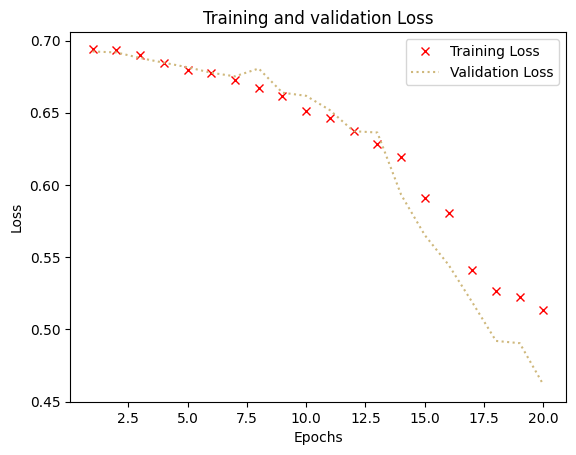

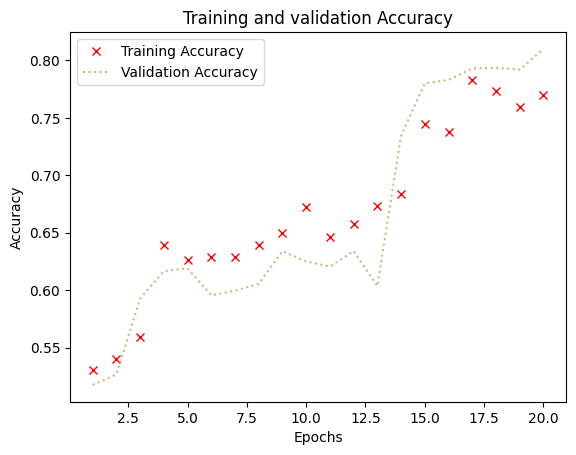

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step

Line 390: validAcc: 0.8100000023841858


In [8]:
pg= parameterGrid4 # This is the scenario the model will be based on.
bestModel, training, validation = buildCNNModel(pg["nFilters1"][0], pg["nFilters2"][0], pg["kernelSize"][0], pg["eta"][0], pg["nTrain"][0], pg["nValid"][0], pg["nStrides"][0] )
bestModel.save("bestValAccCNNModel.keras", include_optimizer=True)

history = bestModel.fit(x=training, validation_data=validation, epochs=pg["nEpoch"][0], batch_size=pg["batchSize"][0]) # verbose=0
validAcc = max(history.history['val_accuracy'])
plotHistoryF(history)
validPred = bestModel.predict(validation)
#print("\nLine 384: validPred:", validPred)
print("\nLine 390: validAcc:", validAcc)


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Results: Confusion Matrix (Validation Set):</h3>



Line 426 Check Lengths of true and predicted label lists: 2000 2000
Accuracy: 0.81
F1: 0.82
Precision: 0.80
Recall: 0.85


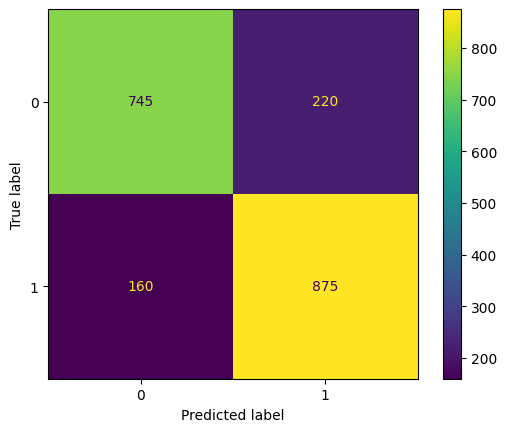

In [16]:
# We need to convert these probabilities to a binary 0/1. I will for now use a 0.5 threshhold.
def setPredLabels(th, predictedLabels):
    threshold = th
    finalPredLabels = predictedLabels.copy().reshape(1,-1)[0]
    finalPredLabels[finalPredLabels>=threshold] = "1"
    finalPredLabels[finalPredLabels<threshold] = "0"
    #print("\nLine 401 validPredLabels", validPredLabels) # validation set predicted labels.
    #print("\nLine 403 Check Lengths of true and predicted label lists:", len(validPredLabels), bestResultD["params"]["nValid"] )
    #print("\nLine 404: ", type(validPredLabels[0])) # predicted labels

    #print("\nLine 409: ", type(validLabels[0]))
    return finalPredLabels

# Confusion Matrix :
def buildConfM( trueLabels, predLabels, fileName):
    confM = confusion_matrix(trueLabels, predLabels)
    confMDisplay = ConfusionMatrixDisplay(confM)
    confMDisplay.plot()
    plt.savefig(fileName)
    print('Accuracy: %.2f' %(accuracy_score(trueLabels, predLabels)))
    print('F1: %.2f' %(f1_score(trueLabels, predLabels)))
    print('Precision: %.2f' %(precision_score(trueLabels, predLabels)))
    print('Recall: %.2f' %(recall_score(trueLabels, predLabels)))
    return

validLabels = validDF.loc[0:pg["nValid"][0]-1, "yLabel"].copy().values.astype(float)
validPredLabels = setPredLabels(0.5, validPred)
print("\nLine 426 Check Lengths of true and predicted label lists:", len(validPredLabels), len(validLabels))

buildConfM(validLabels, validPredLabels, "confMValid.png")




The confusion matrix on the validation set above shows the 81% accuracy (predicted and true label values are the same). True label "0" with predicted label "1" (220 cases, about 11% of the sample) is the case of a non-cancer cell labelled as cancer positive. These are the type of errors that would be easily verified in a second visit of the patient with her oncologists.

True label "1" with predicted label "0" (160 cases, about 8% of the sample) is the case of a cancer cell labelled as cancer negative. 
These are the trouble errors. Future versions of this project should focus on reducing this type of errors.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Results: Confusion Matrix (Test Set):</h3>



Line 413 Test Set Data Generation
Found 29383 validated image filenames.
  1/919 ━━━━━━━━━━━━━━━━━━━━ 1:32 101ms/step

/home/lrt/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


919/919 ━━━━━━━━━━━━━━━━━━━━ 66s 72ms/step

Line 454 Check Lengths of true and predicted label lists: 29383 29383
Accuracy: 0.78
F1: 0.77
Precision: 0.72
Recall: 0.82


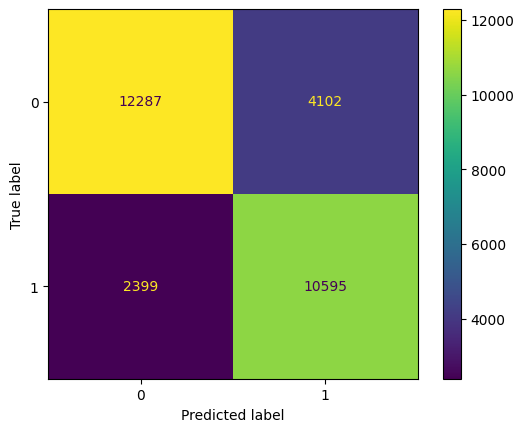

In [15]:
# Final Test on the Test Set:
#=============================
print("\nLine 413 Test Set Data Generation" )
nTest = testDF.shape[0]
test = dataGen.flow_from_dataframe(dataframe = testDF.iloc[0:nTest], directory = testPath, x_col = "fileName", shuffle = False, target_size = (96,96), class_mode= None, classes=None, validate_filenames = True)

testPred = bestModel.predict(test)
testLabels = testDF.loc[0:nTest-1, "yLabel"].copy().values.astype(float)
testPredLabels = setPredLabels(0.5, testPred)
print("\nLine 454 Check Lengths of true and predicted label lists:", len(testPredLabels), len(testLabels))
#print("\nLine 441: test true labels:", testLabels, sum(testLabels))
buildConfM(testLabels, testPredLabels, "confMTest.png")


# Prepare the test set for upload:
#=================================
testDF["id"] = testDF["ImageID"].copy()
testDF["label"] = testPredLabels
testDF["label"] = testDF["label"].astype(int)

# This is the final deliverable:
finalTestDF = testDF[["id","label"]]
finalTestDF.to_csv('finalSubmission.csv', index=False)






<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Final Comments and Conclussions:</h3>

It took 9 hours to train and validate the best model with the whole training and validation data set with a learning rate of eta=0.0001 and epoch=15 iterations. The accuracy achieved is close to 85%. The accuracy vs epoch shows that the curve has not yet tappered off, suggesting that an increase in epoch could lead to an increase in accuracy.

While achieving 85% accuracy may seem like a long process, it is actually a good start. Of the 15% non-accurate labels, some were images of healthy cells missclassified as a cancer positive. This type 2 error can be filtered out during a second follow-up review of the patient. The missclasification of type 1 error --cancer cell images classified as healthy-- should be the focus of attention and that seems to be less than 10%. This 10% error is still too high for this purpose. We should be able to get to 1 type 1 missclasification per 350 million (the entire US population).

I conducted a grid search to tune the hypermarameters. This is a time-consuming, resource-intensive effort. The hyperparameters grid and their values are listed on the grid below:

parameterGrid = {
        "batchSize": [32,64],
        "nStrides": [2,3],
        "nEpoch": [5, 10 ],
        "eta": [0.0005, 0.0001, 0.00001],
        "nFilters1": [32,64], 
        "nFilters2": [32,64], 
        "kernelSize": [ (3,3), (5,5) ],
        "nTrain": [160000, trainDF.shape[0]],
        "nValid": [10000, validDF.shape[0]]
}

This grid search delivers about 600 results. While it will take days to complete, this grid search is not large at all, and it could easily be a lot larger, taking weeks to complete. This running time would be totally justifiable to save a life. However, for the purpose of this paper, I will take the best parameters the grid search could find.

Along with the core hyperparameters, the number of epoch iterations and the size of the dataset used are critical factors to train in less time.

The same model trained with a small fraction of the data (2000 as stated in parameterGrid4) can produce accuracy of 81% on the validation set and 77% on the test. These are sufficient for the purpose of this paper.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  List of References:</h3>

https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

https://github.com/Evan0605/DTSA-5511-CNN-Cancer-Detection-Kaggle-Mini-Project/blob/main/CNN%20Cancer%20Detection%20Kaggle%20Mini-Project.ipynb

https://github.com/IsraelsLibrary/DTSA_5511_CNN_Cancer_Detection_Kaggle_MiniProject

https://github.com/Chiuchiyin/CNN-Cancer-Detection

https://www.kaggle.com/code/ccozad/week-3-cnn-cancer-detection-mini-project

https://github.com/CecileChang/DTSA-5511/blob/main/CNN%20Cancer%20Detection%20Kaggle%20Mini-Project.ipynb

https://github.com/gbainwol/CONVOLUTIONAL_NEURAL_NETWORK_CANCER_PREDICTION_PROJECT

https://github.com/IvMonares/CNN_Cancer_Detection

https://github.com/clebastard21/DTSA-5511-Histopathologic-Cancer-Detection/blob/main/README.md

https://github.com/binyammesfin/DTSA-5511---Cancer-Detection-Kaggle-Mini-Project

https://github.com/23yem/Kaggle-Histopathologic-Cancer-Detection

https://annasanders.github.io/ms_projects/dtsa5511_cnncancer

https://github.com/basveeling/pcam

https://www.tensorflow.org/tutorials/keras/text_classification
